In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

#using Profile
#using ProfileVega

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");

chemical_data = cdata_list[1]

println("Molecule name: ", chemical_data.mol_name)
println("Basis set: ", chemical_data.basis)
println("Molecular geometry: ", chemical_data.geometry)
println("RHF energy: ", chemical_data.e_rhf)
println("FCI energy: ", chemical_data.e_fci)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation:

sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

hf_ord = collect(1:chemical_data.N_spt)

opsum = GenOpSum(chemical_data, hf_ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.01536933260759
Expected particle number: 10
Particle number: 10.000000000000005


In [4]:
Ipq = MutualInformation(psi, chemical_data, dim=4);

display(Ipq)

7×7 Matrix{Float64}:
 0.0         1.01319e-5   2.14014e-6   …  1.34049e-6  4.45901e-6
 1.01319e-5  0.0          0.00816113      0.0109367   0.00870843
 2.14014e-6  0.00816113   0.0             0.0451483   0.0710614
 1.93387e-6  0.00947491   0.0307159       0.0457578   0.0315419
 8.44845e-7  0.000266946  0.000677021     0.00453371  0.000440876
 1.34049e-6  0.0109367    0.0451483    …  0.0         0.0438309
 4.45901e-6  0.00870843   0.0710614       0.0438309   0.0

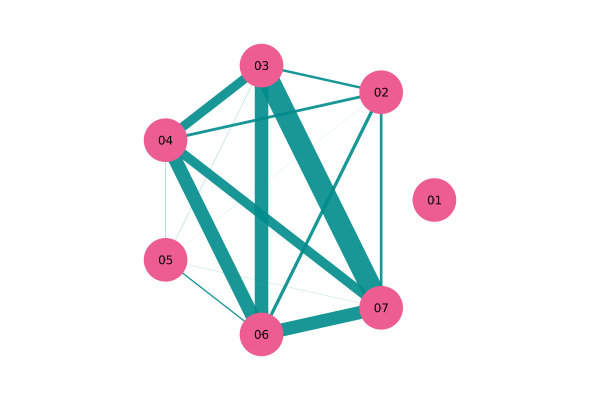

In [5]:
OrbitalGraphPlot(Ipq, multiplier=300)

In [6]:
ord = SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)

println(ord)

[1, 7, 3, 6, 4, 2, 5]


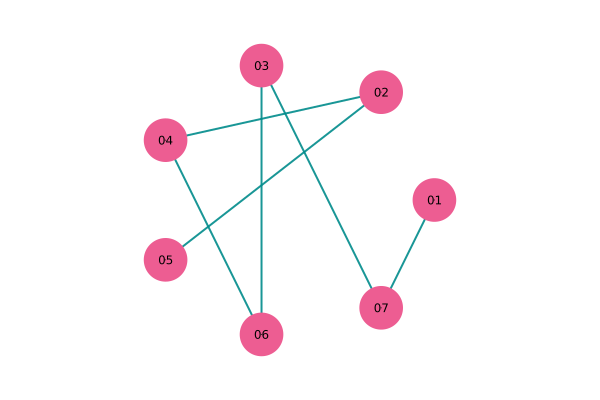

In [7]:
OrbitalGraphPlot(GraphMat(ord, directed=false), multiplier=2)

In [8]:
opsum = GenOpSum(chemical_data, ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.0188386680321
Expected particle number: 10
Particle number: 10.000000000000007


-0.19896577948041438
19


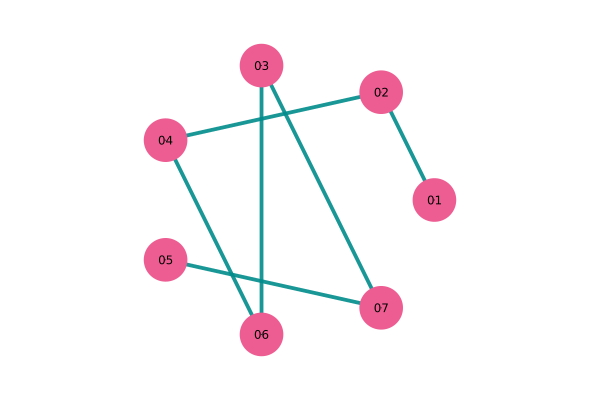

In [9]:
# Generate priority orderings:


ord_list = []

ord, inf = SimulatedAnnealing(Ipq, steps=1e6, swap_mult=3.0, tpow=5, return_inf=true)

println(inf)

push!(ord_list, ord)

# Just use the same geometry over:
ord_list = vcat(ord_list, [ord for i=1:18])

# Use a selection of highest priority chains:
#ord_list = vcat(ord_list, PriorityOrderings([6,6,6,6], Ipq))

# Use a modified distance measure over a set of geometries:
"""
ord_list = vcat(ord_list, SimulatedAnnealing(Ipq, M=36, cost_func="mixdist", gamma=0.9, steps=1e4, swap_mult=3.0, tpow=5))
"""

# "Greedy" annealer to find local minima (in edge-constrained search space)
"""
edges = PriorityChains(Ipq, 12, 1)
println(edges)
for edge in edges
    for i=1:5
        push!(ord_list, SimulatedAnnealing(Ipq, constrained_edges=[edge], steps=1e2, swap_mult=3.0, greedy=true))
    end
end
"""

println(length(ord_list))

graph_mat = zeros(chemical_data.N_spt,chemical_data.N_spt)

for ord in ord_list
    graph_mat += GraphMat(ord, directed=false)
end

OrbitalGraphPlot(graph_mat, multiplier=0.2)


In [10]:
# Get the H and S matrices:

global_maxdim = 3

sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

opt_sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(opt_sweeps,global_maxdim) # gradually increase states kept
cutoff!(opt_sweeps,1E-10) # desired truncation error
setnoise!(opt_sweeps,1e-4,1e-6,1e-8,0.0)

noisy_sweeps = Sweeps(4) # number of sweeps is 5
maxdim!(noisy_sweeps,global_maxdim) # gradually increase states kept
cutoff!(noisy_sweeps,1E-10) # desired truncation error
setnoise!(noisy_sweeps,1e-2)

psi_opt, ham_opt = GenStates(
    chemical_data, 
    sites, 
    [ord_list[1]], 
    noisy_sweeps, 
    ovlp_opt=false,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    ham_tol=1E-8, 
    ham_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
)


psi_noisy, ham_noisy = GenStates(
    chemical_data, 
    sites, 
    ord_list[2:length(ord_list)], 
    noisy_sweeps, 
    ovlp_opt=false,
    weight=1e6,
    prior_states=psi_opt,
    prior_ords=[ord_list[1]],
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    ham_tol=1E-10, 
    ham_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
)


psi_list = vcat(psi_opt, psi_noisy)
ham_list = vcat(ham_opt, ham_noisy)

H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [18/18] 
Done!
computing matrix elements:
Progress: [190/190] 
Done!


In [11]:
##### Solve the generalized eigenvalue problem:

display(round.(S_mat,digits=3))

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="inversion", eps=1e-8)

e_gnd = minimum(filter(!isnan,real.(E)))+chemical_data.e_nuc
e_bsrf = minimum(diag(H_mat))+chemical_data.e_nuc

println("Minimum eigenvalue: ", minimum(filter(!isnan,real.(E))))
println("Condition number: ", kappa)

println("FCI energy: ", chemical_data.e_fci)
println("Final energy estimate: ", e_gnd)
println("Best single ref. estimate: ", e_bsrf)

println("Error: ", e_gnd - chemical_data.e_fci)
println("BSRfE: ", e_bsrf - chemical_data.e_fci)
println("Improvement: ", e_bsrf - e_gnd)
println("Percentage error reduction: ", (e_bsrf - e_gnd)/(e_bsrf - chemical_data.e_fci)*100)

19×19 Matrix{Float64}:
  1.0    -1.0    -1.0     0.994   0.994  …  -1.0    -1.0    -0.994  -0.997
 -1.0     1.0     1.0    -0.994  -0.994      1.0     1.0     0.994   0.997
 -1.0     1.0     1.0    -0.994  -0.994      1.0     1.0     0.994   0.997
  0.994  -0.994  -0.994   1.0     1.0       -0.994  -0.994  -1.0    -0.997
  0.994  -0.994  -0.994   1.0     1.0       -0.994  -0.994  -1.0    -0.997
  0.994  -0.994  -0.994   1.0     1.0    …  -0.994  -0.994  -1.0    -0.997
 -1.0     1.0     1.0    -0.994  -0.994      1.0     1.0     0.994   0.997
 -1.0     1.0     1.0    -0.994  -0.994      1.0     1.0     0.994   0.997
  0.994  -0.994  -0.994   1.0     1.0       -0.994  -0.994  -1.0    -0.997
  0.994  -0.994  -0.994   1.0     1.0       -0.994  -0.994  -1.0    -0.997
 -0.994   0.994   0.994  -1.0    -1.0    …   0.994   0.994   1.0     0.997
  1.0    -1.0    -1.0     0.994   0.994     -1.0    -1.0    -0.994  -0.997
  1.0    -1.0    -1.0     0.994   0.994     -1.0    -1.0    -0.994  -0.997
  

Minimum eigenvalue: -83.84121393217131
Condition number: 5057.579768334523
FCI energy: -75.01927599660624
Final energy estimate: -75.0001937631604
Best single ref. estimate: -74.9961891767785
Error: 0.019082233445843144
BSRfE: 0.02308681982773919
Improvement: 0.004004586381896047
Percentage error reduction: 17.34576876233283


In [12]:
kappa_list = EigCondNums(E, C)
println(round.(kappa_list, digits=4))

ComplexF64[0.0119 + 0.0im, 0.0121 + 0.0im, 0.0121 + 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 - 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 - 0.0im, 1.0 + 0.0im, 1.0 - 0.0im]


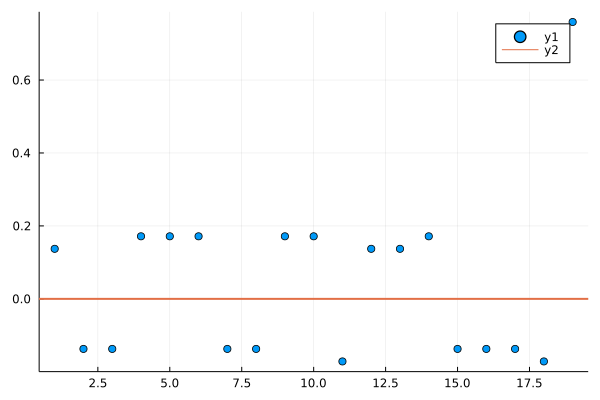

In [13]:
scatter(collect(1:length(C[:,1])), real.(C[:,1]),lw=2)
hline!([0.0], lw=2)

In [14]:
re_psi_list = NLOptimizeStates(
    chemical_data,
    psi_list,
    ham_list,
    ord_list;
    tol=1e-12,
    maxdim=global_maxdim,
    perm_tol=1e-12,
    perm_maxdim=5000,
    loops=2,
    sweeps=1,
    thresh="projection",
    eps=1e-8,
    verbose=true
);

Starting energy: -83.84121393217228
Run 1 of 2:

Optimizing state 1 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.84736720404295
Condition number: 8404.938877523646
Done!
Optimizing state 2 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.84882143041575
Condition number: 8277.443002893062
Done!
Optimizing state 3 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.8493818149043
Condition number: 8771.980191630722
Done!
Optimizing state 4 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85036585410636
Condition number: 8398.965148091804
Done!
Optimizing state 5 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85128271267189
Condition number: 7863.610507999176
Done!
Optimizing state 6 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.8522596717175
Condition number: 7541.485588060237
Done!
Optimizing 

computing matrix elements:
Progress: [190/190] 
Done!


19×19 Matrix{Float64}:
  1.0          0.0305826    0.248925    …   0.159238     0.159035
  0.0305826    1.0          0.0703021       0.211993     0.21287
  0.248925     0.0703021    1.0             0.220745     0.219753
  0.0316005    0.06781     -0.123389        0.174812     0.20114
 -0.00972344  -0.0369625   -0.0981052      -0.00984581  -0.0251737
 -0.0383337   -0.144955     0.107977    …  -0.34303     -0.350408
 -0.166328     0.101549     0.0994587       0.833878     0.836782
  0.0566688   -0.0659252   -0.119852        0.151102     0.153496
 -0.0704441   -0.00887142  -0.336422       -0.376393    -0.394732
 -0.0450648   -0.119534     0.035953       -0.388201    -0.380376
  0.0164494   -0.0731518    0.112896    …  -0.0154275    0.00642823
 -0.106685    -0.0980073   -0.170554       -0.10456     -0.106399
  0.0631297    0.179666    -0.00497759     -0.164634    -0.16673
  0.0179368   -0.0220774    0.0207226       0.109338     0.0943779
 -0.0971723   -0.245764    -0.582098       -0.142722

Minimum eigenvalue: -83.85322495473083
Condition number: 6197.537485071198
FCI energy: -75.01927599660624
Final energy estimate: -75.01220478571992
Best single ref. estimate: -74.99618917456803
Error: 0.0070712108863233425
BSRfE: 0.02308682203820922
Improvement: 0.016015611151885878
Percentage error reduction: 69.37122452531437
[0.0285, 3.1313, 1.8827, 5.502, 0.5814, 1.609, 0.9957, 0.4582, 0.1328, 1.3223, 0.0682, 0.3144, 2.5129, 0.7701, 0.6892, 1.3167, 0.1303, 0.6373, 0.0716]


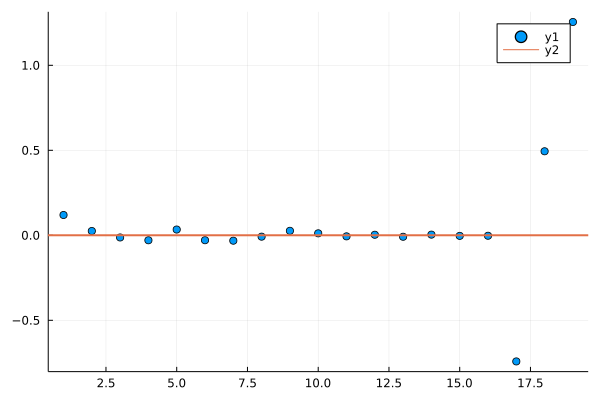

In [15]:
H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    re_psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

##### Solve the generalized eigenvalue problem:

display(S_mat)

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="none", eps=1e-9)

e_gnd = minimum(filter(!isnan,real.(E)))+chemical_data.e_nuc
e_bsrf = minimum(diag(H_mat))+chemical_data.e_nuc

println("Minimum eigenvalue: ", minimum(filter(!isnan,real.(E))))
println("Condition number: ", kappa)

println("FCI energy: ", chemical_data.e_fci)
println("Final energy estimate: ", e_gnd)
println("Best single ref. estimate: ", e_bsrf)

println("Error: ", e_gnd - chemical_data.e_fci)
println("BSRfE: ", e_bsrf - chemical_data.e_fci)
println("Improvement: ", e_bsrf - e_gnd)
println("Percentage error reduction: ", (e_bsrf - e_gnd)/(e_bsrf - chemical_data.e_fci)*100)

kappa_list = EigCondNums(E, C)
println(round.(kappa_list, digits=4))

scatter(collect(1:length(C[:,1])), real.(C[:,1]),lw=2)
hline!([0.0], lw=2)


In [16]:
e_corr = chemical_data.e_fci-chemical_data.e_rhf

e_corr_dmrg = e_bsrf - chemical_data.e_rhf

e_corr_tnqe = e_gnd - chemical_data.e_rhf

pctg_dmrg = e_corr_dmrg/e_corr*100

pctg_tnqe = e_corr_tnqe/e_corr*100

println("Percent correlation energy with single-geometry DMRG: $pctg_dmrg")
println("Percent correlation energy with single-geometry TNQE: $pctg_tnqe")

Percent correlation energy with single-geometry DMRG: 60.26696813409351
Percent correlation energy with single-geometry TNQE: 87.83025888050621
